Run simplified odor search model for different conditions using different behavioral correlates of "search progress".

Non-odor sensorimotor process variables:

$b_j(t)$ = forward vel, abs ang vel, abs heading.

$$s(t) = \int_{t^i}^t (b_1*h_1 + ... + b_m*h_m) dt'$$

where $t^i$ is time of last odor pulse, $b_j(t)$ are different behavioral time-series, and $h_j(t)$ are the corresponding filters for those behaviors.

Locomotor process

$$\tau\frac{d\mathbf{v}}{dt} = -\mathbf{v} + \eta + s_0 \hat{\mathbf{v}}\sum_i \delta(t - t_i)s(t_i)$$

Expectations: if heading filter is nonzero, should get anisotropy in overall distribution of positions explored in response to odor detection.

Environment: $X \times X$ arena.
Each odor source is placed in arena completely at random at location $\mathbf{z}_{pl}$. Same with insect start location $\mathbf{x}_0$.

Plume structure: uniform detection rate $r$ w/in plume envelope. Total area $A_{pl}$

Plume A: circular envelope of radius $r_c = \sqrt{A_{pl}/\pi}$

Plume B: triangular envelope with width $w$ and length $l = 2A_{pl}/b$.

Source is reached if agent wanders within $r_s$ of source location.

In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


X = 1  # m
DT = 0.01  # s
SGM = .1  # m/s * \sqrt(s)
TAU = .5  # s
T_H = 5  # s
T = 120  # s
A = .125  # m^2
W = .25  # m
R = 1  # Hz
R_S = .05  # m
S_0 = .5  # m/s

R_C = np.sqrt(A/np.pi)
L = 2*A/W

# filters
t = np.arange(0, T, DT)
t_h = np.arange(0, T_H, DT)


np.random.seed(0)

def run(shape, z_pl, x_0):
    
    def detect(x):
        if np.linalg.norm(x - z_pl) < R_S:
            return 2
        
        if (shape == 'circle') and (np.linalg.norm(x - z_pl) < R_C):
            return int(np.random.rand() < R*DT)

        elif shape == 'triangle':
            # check if x in triangle defined by plume
            if ((z_pl[1] - L) <= x[1] < (z_pl[1])) and ((z_pl[0] - W/2) <= x[0] < (z_pl[0] + W/2)):
                if x[1] < (z_pl[1] - np.abs((2*L/W)*(x[0] - z_pl[0]))):
                    return int(np.random.rand() < R*DT)
        return 0
    
    xs = np.nan * np.zeros((len(t), 2))
    vs = np.nan * np.zeros((len(t), 2))
    h_abs = np.nan * np.zeros(len(t))
    
    hits = []
    
    xs[0, :] = x_0
    vs[0, :] = 0.
    
    for t_ctr, t_ in enumerate(t[1:], 1):
        
        # detect plume
        detection = detect(xs[t_ctr-1, :])
        if detection == 1:
            hits.append((t_-DT, xs[t_ctr-1, 0], xs[t_ctr-1, 1]))
        elif detection == 2:
            t_find = t_ - 1
            break
            
        eta = np.random.randn(2) * SGM/np.sqrt(DT)
        
        if t_ctr > 1:
            v_hat = vs[t_ctr-1, :] / np.linalg.norm(vs[t_ctr-1, :])
            bias = detection * S_0 * v_hat * float(h_abs[t_ctr-1] < np.pi/4)
        else:
            bias = 0
            
        dv = (DT/TAU) * (-vs[t_ctr-1, :] + eta) + bias
        vs[t_ctr, :] = vs[t_ctr-1, :] + dv
        dx = DT * vs[t_ctr, :]
        xs[t_ctr, :] = xs[t_ctr-1, :] + dx
        
        if xs[t_ctr, 0] > X:
            xs[t_ctr, 0] = X
            vs[t_ctr, 0] = 0
        if xs[t_ctr, 0] < 0:
            xs[t_ctr, 0] = 0
            vs[t_ctr, 0] = 0
        if xs[t_ctr, 1] > X:
            xs[t_ctr, 1] = X
            vs[t_ctr, 1] = 0
        if xs[t_ctr, 1] < 0:
            xs[t_ctr, 1] = 0
            vs[t_ctr, 1] = 0
        
        if not np.all(vs[t_ctr, :] == 0):
            h_abs[t_ctr] = np.abs(np.arctan2(*vs[t_ctr, :]))

    else:
        t_find = -1
        
    return t, xs, vs, h_abs, x_0, z_pl, np.array(hits), t_find

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


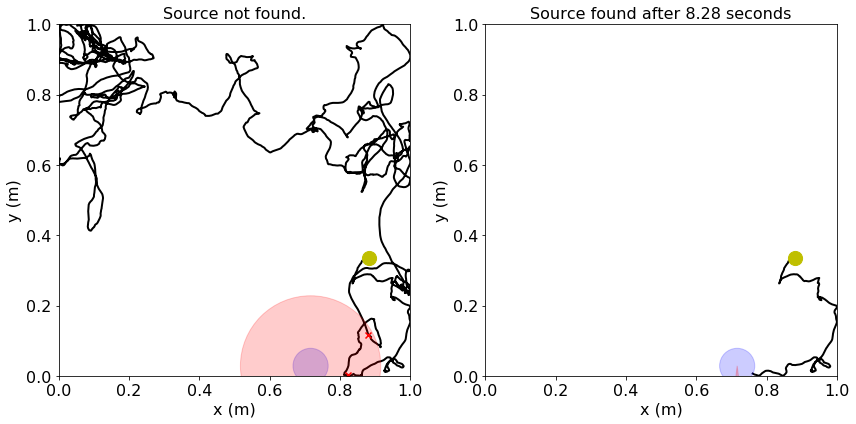

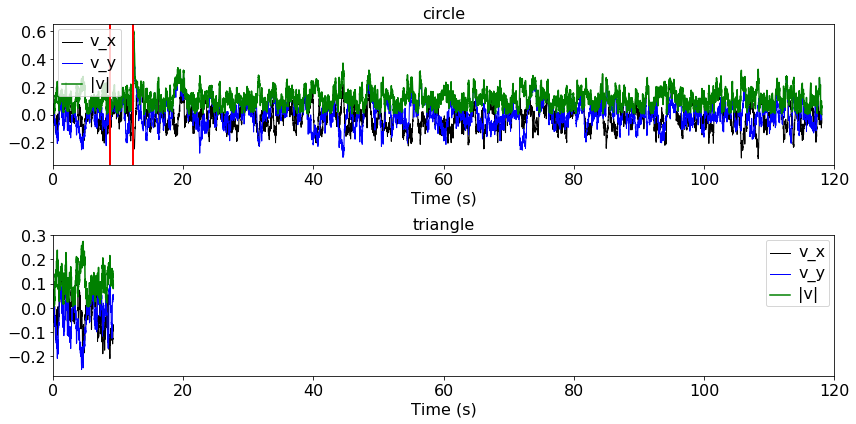

In [2]:
np.random.seed(None)
seed = np.random.randint(0, 1000)
z_pl = np.random.uniform(0, X, 2)
x_0 = np.random.uniform(0, X, 2)

fig, axs_xy = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
fig, axs_t = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)

t_finds = []

for shape, ax_xy, ax_t in zip(['circle', 'triangle'], axs_xy, axs_t):
    
    np.random.seed(seed)
    t, xs, vs, h_abs, x_0, z_pl, hits, t_find = run(shape, z_pl, x_0)

    ax_xy.plot(xs[:, 0], xs[:, 1], lw=2, c='k', zorder=0)
    ax_xy.scatter(*x_0, c='y', s=200, zorder=1)

    if len(hits) > 0:
        ax_xy.scatter(hits[:, 1], hits[:, 2], color='r', marker='x')

    src_circle = plt.Circle(z_pl, R_S, color='b', alpha=.2)
    ax_xy.add_artist(src_circle)

    if shape == 'circle':
        circle = plt.Circle(z_pl, R_C, color='r', alpha=.2)
        ax_xy.add_artist(circle)
    elif shape == 'triangle':
        triangle = plt.Polygon([z_pl, [z_pl[0]-W/2, z_pl[1]-L], [z_pl[0]+W/2, z_pl[1]-L]], color='r', alpha=.2)
        ax_xy.add_artist(triangle)

    ax_xy.set_xlim(0, X)
    ax_xy.set_ylim(0, X)

    ax_xy.set_xlabel('x (m)')
    ax_xy.set_ylabel('y (m)')

    if t_find >= 0:
        ax_xy.set_title('Source found after {} seconds'.format(t_find))
    else:
        ax_xy.set_title('Source not found.')

    set_font_size(ax_xy, 16)
    
    ax_t.plot(t, vs[:, 0], color='k', lw=1)
    ax_t.plot(t, vs[:, 1], color='b', lw=1)
    ax_t.plot(t, np.sqrt(vs[:, 0]**2 + vs[:, 1]**2), color='g')
    
    ax_t.legend(['v_x', 'v_y', '|v|'])

    for hit in hits:
        ax_t.axvline(hit[0], c='r', lw=2)
        
    ax_t.set_xlim(0, T)
    ax_t.set_xlabel('Time (s)')
    ax_t.set_title(shape)
    
    set_font_size(ax_t, 16)

In [3]:
t_finds = []

for smln_ctr in range(1000):
    sys.stdout.write('.')
    np.random.seed(None)
    seed = np.random.randint(0, 1000)
    z_pl = np.random.uniform(0, X, 2)
    x_0 = np.random.uniform(0, X, 2)

    t_find = []
    
    for shape, ax_xy, ax_t in zip(['circle', 'triangle'], axs_xy, axs_t):

        np.random.seed(seed)
        t, xs, vs, h_abs, x_0, z_pl, hits, t_find_ = run(shape, z_pl, x_0)
        
        t_find.append(t_find_)
    
    t_finds.append(t_find)
        
t_finds = np.array(t_finds)
print('')
print('Complete')

........

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Complet

Success probability

In [4]:
print('Circle plume success prob = {}'.format(np.mean(t_finds[:, 0] > -1)))
print('Triangle plume success prob = {}'.format(np.mean(t_finds[:, 1] > -1)))

Circle plume success prob = 0.433
Triangle plume success prob = 0.545


Localization efficiency

In [5]:
print('Circle plume mean search time = {}'.format(np.mean(t_finds[(t_finds[:, 0] > -1), 0])))
print('Triangle plume mean search time = {}'.format(np.mean(t_finds[(t_finds[:, 1] > -1), 1])))

Circle plume mean search time = 47.0605311778291
Triangle plume mean search time = 47.89150458715597


In [6]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


X = 1  # m
DT = 0.01  # s
SGM = .1  # m/s * \sqrt(s)
TAU = .5  # s
T_H = 5  # s
T = 120  # s
A = .125  # m^2
W = .25  # m
R = 1  # Hz
R_S = .05  # m
S_0 = .5  # m/s

R_C = np.sqrt(A/np.pi)
L = 2*A/W

# filters
t = np.arange(0, T, DT)
t_h = np.arange(0, T_H, DT)


np.random.seed(0)

def run(shape, z_pl, x_0):
    
    def detect(x):
        if np.linalg.norm(x - z_pl) < R_S:
            return 2
        
        if (shape == 'circle') and (np.linalg.norm(x - z_pl) < R_C):
            return int(np.random.rand() < R*DT)

        elif shape == 'triangle':
            # check if x in triangle defined by plume
            if ((z_pl[1] - L) <= x[1] < (z_pl[1])) and ((z_pl[0] - W/2) <= x[0] < (z_pl[0] + W/2)):
                if x[1] < (z_pl[1] - np.abs((2*L/W)*(x[0] - z_pl[0]))):
                    return int(np.random.rand() < R*DT)
        return 0
    
    xs = np.nan * np.zeros((len(t), 2))
    vs = np.nan * np.zeros((len(t), 2))
    h_abs = np.nan * np.zeros(len(t))
    
    hits = []
    
    xs[0, :] = x_0
    vs[0, :] = 0.
    
    for t_ctr, t_ in enumerate(t[1:], 1):
        
        # detect plume
        detection = detect(xs[t_ctr-1, :])
        if detection == 1:
            hits.append((t_-DT, xs[t_ctr-1, 0], xs[t_ctr-1, 1]))
        elif detection == 2:
            t_find = t_ - 1
            break
            
        eta = np.random.randn(2) * SGM/np.sqrt(DT)
        
        if t_ctr > 1:
            v_hat = vs[t_ctr-1, :] / np.linalg.norm(vs[t_ctr-1, :])
            bias = detection * S_0 * v_hat * float(h_abs[t_ctr-1] < np.pi)
        else:
            bias = 0
            
        dv = (DT/TAU) * (-vs[t_ctr-1, :] + eta) + bias
        vs[t_ctr, :] = vs[t_ctr-1, :] + dv
        dx = DT * vs[t_ctr, :]
        xs[t_ctr, :] = xs[t_ctr-1, :] + dx
        
        if xs[t_ctr, 0] > X:
            xs[t_ctr, 0] = X
            vs[t_ctr, 0] = 0
        if xs[t_ctr, 0] < 0:
            xs[t_ctr, 0] = 0
            vs[t_ctr, 0] = 0
        if xs[t_ctr, 1] > X:
            xs[t_ctr, 1] = X
            vs[t_ctr, 1] = 0
        if xs[t_ctr, 1] < 0:
            xs[t_ctr, 1] = 0
            vs[t_ctr, 1] = 0
        
        if not np.all(vs[t_ctr, :] == 0):
            h_abs[t_ctr] = np.abs(np.arctan2(*vs[t_ctr, :]))

    else:
        t_find = -1
        
    return t, xs, vs, h_abs, x_0, z_pl, np.array(hits), t_find

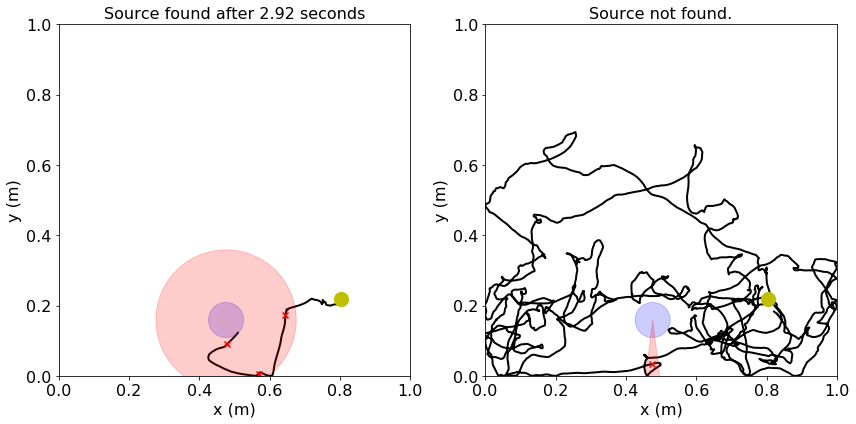

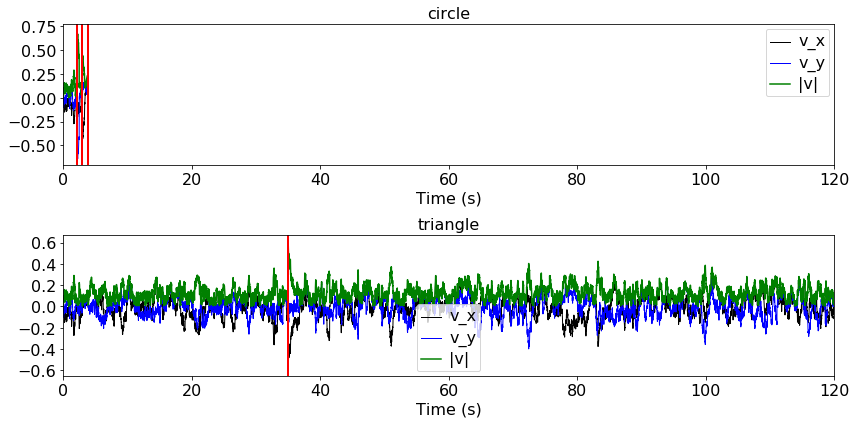

In [7]:
np.random.seed(None)
seed = np.random.randint(0, 1000)
z_pl = np.random.uniform(0, X, 2)
x_0 = np.random.uniform(0, X, 2)

fig, axs_xy = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
fig, axs_t = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)

t_finds = []

for shape, ax_xy, ax_t in zip(['circle', 'triangle'], axs_xy, axs_t):
    
    np.random.seed(seed)
    t, xs, vs, h_abs, x_0, z_pl, hits, t_find = run(shape, z_pl, x_0)

    ax_xy.plot(xs[:, 0], xs[:, 1], lw=2, c='k', zorder=0)
    ax_xy.scatter(*x_0, c='y', s=200, zorder=1)

    if len(hits) > 0:
        ax_xy.scatter(hits[:, 1], hits[:, 2], color='r', marker='x')

    src_circle = plt.Circle(z_pl, R_S, color='b', alpha=.2)
    ax_xy.add_artist(src_circle)

    if shape == 'circle':
        circle = plt.Circle(z_pl, R_C, color='r', alpha=.2)
        ax_xy.add_artist(circle)
    elif shape == 'triangle':
        triangle = plt.Polygon([z_pl, [z_pl[0]-W/2, z_pl[1]-L], [z_pl[0]+W/2, z_pl[1]-L]], color='r', alpha=.2)
        ax_xy.add_artist(triangle)

    ax_xy.set_xlim(0, X)
    ax_xy.set_ylim(0, X)

    ax_xy.set_xlabel('x (m)')
    ax_xy.set_ylabel('y (m)')

    if t_find >= 0:
        ax_xy.set_title('Source found after {} seconds'.format(t_find))
    else:
        ax_xy.set_title('Source not found.')

    set_font_size(ax_xy, 16)
    
    ax_t.plot(t, vs[:, 0], color='k', lw=1)
    ax_t.plot(t, vs[:, 1], color='b', lw=1)
    ax_t.plot(t, np.sqrt(vs[:, 0]**2 + vs[:, 1]**2), color='g')
    
    ax_t.legend(['v_x', 'v_y', '|v|'])

    for hit in hits:
        ax_t.axvline(hit[0], c='r', lw=2)
        
    ax_t.set_xlim(0, T)
    ax_t.set_xlabel('Time (s)')
    ax_t.set_title(shape)
    
    set_font_size(ax_t, 16)

In [8]:
t_finds = []

for smln_ctr in range(1000):
    sys.stdout.write('.')
    np.random.seed(None)
    seed = np.random.randint(0, 1000)
    z_pl = np.random.uniform(0, X, 2)
    x_0 = np.random.uniform(0, X, 2)

    t_find = []
    
    for shape, ax_xy, ax_t in zip(['circle', 'triangle'], axs_xy, axs_t):

        np.random.seed(seed)
        t, xs, vs, h_abs, x_0, z_pl, hits, t_find_ = run(shape, z_pl, x_0)
        
        t_find.append(t_find_)
    
    t_finds.append(t_find)
        
t_finds = np.array(t_finds)
print('')
print('Complete')

...........

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Complete


Success probability

In [9]:
print('Circle plume success prob = {}'.format(np.mean(t_finds[:, 0] > -1)))
print('Triangle plume success prob = {}'.format(np.mean(t_finds[:, 1] > -1)))

Circle plume success prob = 0.444
Triangle plume success prob = 0.491


Localization efficiency

In [10]:
print('Circle plume mean search time = {}'.format(np.mean(t_finds[(t_finds[:, 0] > -1), 0])))
print('Triangle plume mean search time = {}'.format(np.mean(t_finds[(t_finds[:, 1] > -1), 1])))

Circle plume mean search time = 45.54423423423424
Triangle plume mean search time = 46.28959266802445


$$\tau^i = \frac{C}{g^i_L}$$